
# Sustainability Forecast Lab  

*Auto‑generated 2025-04-17 00:54 UTC*  

This notebook unifies:

1. **Phase 1 – Data intake & tidy export**  
2. **Phase 2 – Feature engineering, missing‑data policy, correlation analysis**  
3. **Phase 3 – Clustering & model comparison for forecasting**  

> **Folder structure expected**

```
project/
├── data_raw/
│   ├── NFA 2018.csv
│   ├── co-emissions-per-capita/...
│   ├── API_EG/...
│   ├── API_NY/...
│   ├── API_ER/...
│   └── HDR23-24_Statistical_Annex_HDI_Table.xlsx
├── data_work/        # generated
└── models/           # generated
```

Place downloads exactly under `data_raw/`.  
All subsequent paths are created automatically.


## Phase 1 – Load raw files & write tidy CSVs

In [9]:

import os, glob, re, zipfile, pandas as pd, warnings, datetime, json
warnings.filterwarnings('ignore')

DATA_RAW, DATA_WORK = 'data_raw', 'data_work'
os.makedirs(DATA_WORK, exist_ok=True)

def load_wb_wide(path, value_name):
    df = pd.read_csv(path, skiprows=4)
    year_cols = [c for c in df.columns if re.fullmatch(r'\d{4}', str(c))]
    tidy = (df.melt(id_vars=['Country Code'], value_vars=year_cols,
                    var_name='year', value_name=value_name)
              .rename(columns={'Country Code':'iso3'}))
    tidy['year'] = tidy['year'].astype(int)
    return tidy.dropna(subset=[value_name])

datasets={}
datasets['footprint']=pd.read_csv(f'{DATA_RAW}/NFA 2018.csv').rename(columns={'ISO alpha-3 code':'iso3'})
datasets['co2_pc']=(pd.read_csv(f'{DATA_RAW}/co-emissions-per-capita/co-emissions-per-capita.csv')
    .rename(columns={'Code':'iso3','Annual CO₂ emissions (per capita)':'co2_pc'})
    [['iso3','Year','co2_pc']].rename(columns={'Year':'year'}))
datasets['renew_pct']=load_wb_wide(glob.glob(f'{DATA_RAW}/API_EG/API_EG.*.csv')[0],'renew_pct')
datasets['rent_pct_gdp']=load_wb_wide(glob.glob(f'{DATA_RAW}/API_NY/API_NY.*.csv')[0],'rent_pct_gdp')
datasets['protected_pct']=load_wb_wide(glob.glob(f'{DATA_RAW}/API_ER/API_ER.*.csv')[0],'protected_pct')

for k,df in datasets.items():
    df.to_csv(f'{DATA_WORK}/{k}.csv',index=False)
print('✅ Tidy CSVs written to', DATA_WORK)


✅ Tidy CSVs written to data_work


## Phase 2 – Feature engineering & EDA

Remaining NA % (numeric) : 0.114


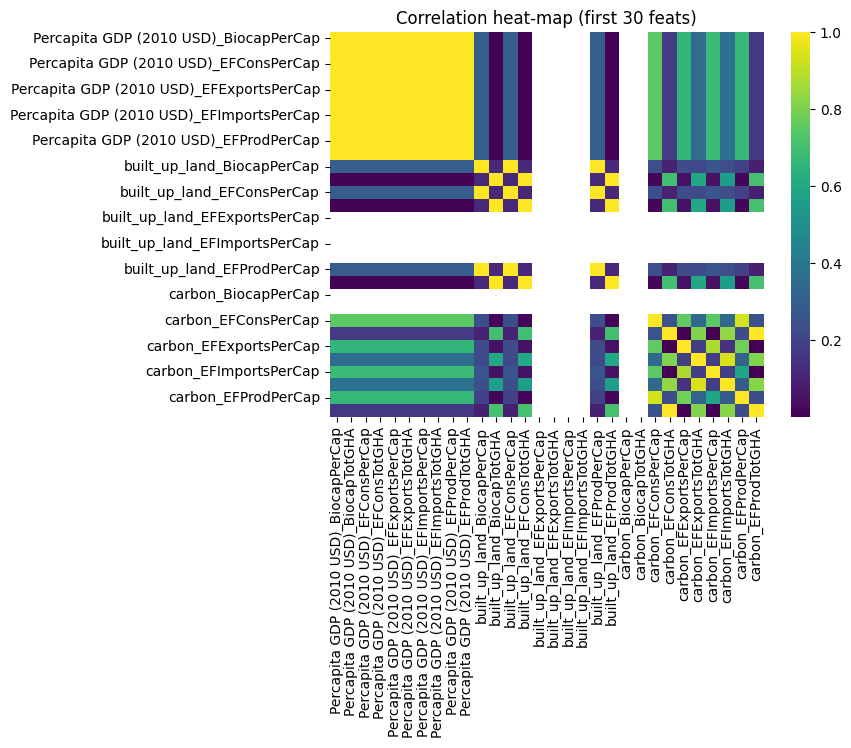

🚀 Features saved: data_work/features_full.csv


In [4]:

import pandas as pd, numpy as np, glob, os, re, warnings, matplotlib.pyplot as plt, seaborn as sns
warnings.filterwarnings('ignore')
DATA_WORK='data_work'
datasets={os.path.basename(f).replace('.csv',''):pd.read_csv(f) for f in glob.glob(f'{DATA_WORK}/*.csv')}

# 1. widen footprint
foot=datasets['footprint']
num_cols=['crop_land','grazing_land','forest_land','fishing_ground',
          'built_up_land','carbon','total','Percapita GDP (2010 USD)','population']
long=foot.melt(id_vars=['iso3','year','record'],value_vars=num_cols,
               var_name='var',value_name='val')
long['feat']=long['var']+'_'+long['record']
foot_wide = (
    long.pivot_table(
        index=['iso3', 'year'],
        columns='feat',
        values='val',
        aggfunc='first'          # or np.mean – but values are identical
    )
    .reset_index()
)

panel=foot_wide.copy()
for k in ['co2_pc','renew_pct','rent_pct_gdp','protected_pct']:
    panel=panel.merge(datasets[k],on=['iso3','year'],how='left')

# 2. Missing‑data strategy
panel=panel.sort_values(['iso3','year'])
panel=panel.groupby('iso3').apply(lambda g:g.ffill().bfill()).reset_index(drop=True)
for col in ['renew_pct','protected_pct','rent_pct_gdp']:
    panel[col]=panel.groupby('year')[col].transform(lambda x:x.fillna(x.median()))
print('Remaining NA % (numeric) :', panel.select_dtypes('number').isna().mean().max().round(3))

# 3. Lag & delta
num_feats=panel.select_dtypes('number').columns.difference(['year'])
for c in num_feats:
    panel[f'{c}_lag1']=panel.groupby('iso3')[c].shift(1)
    panel[f'd_{c}']=panel.groupby('iso3')[c].diff()

# 4. Correlation inspection
plt.figure(figsize=(7,5))
sns.heatmap(panel[num_feats[:30]].corr().abs(),cmap='viridis')
plt.title('Correlation heat‑map (first 30 feats)')
plt.show()

panel.to_csv(f'{DATA_WORK}/features_full.csv',index=False)
print('🚀 Features saved:', f'{DATA_WORK}/features_full.csv')


## Phase 3 – Clustering & Model comparison

### 3.1 Clustering countries on most‑recent snapshot

Best k via silhouette = 2


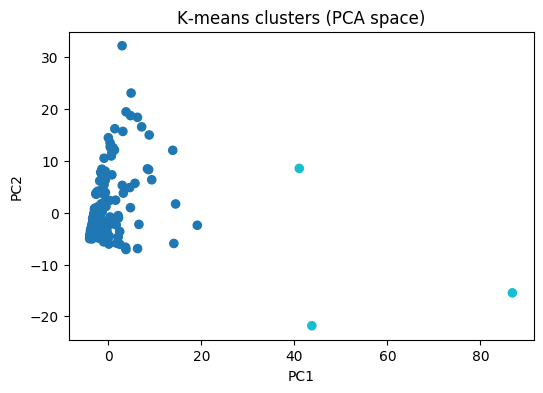

Cluster sizes:
 kmeans_cluster
0    190
1      3
Name: count, dtype: int64


In [5]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt, numpy as np, pandas as pd, os

panel=pd.read_csv(f'{DATA_WORK}/features_full.csv')
# take latest year per iso
latest=panel.groupby('iso3')['year'].max().reset_index()
panel_last=panel.merge(latest,on=['iso3','year'])
X=panel_last.select_dtypes('number').drop(columns=['year']).fillna(0)
X_scaled=StandardScaler().fit_transform(X)

# k‑means elbow & silhouette
sil=[]
for k in range(2,8):
    lbl=KMeans(n_clusters=k,n_init=10,random_state=42).fit_predict(X_scaled)
    sil.append(silhouette_score(X_scaled,lbl))
best_k=int(np.argmax(sil))+2
print('Best k via silhouette =', best_k)

kmeans=KMeans(n_clusters=best_k,n_init=10,random_state=42)
panel_last['kmeans_cluster']=kmeans.fit_predict(X_scaled)

# optional GMM clustering
gmm=GaussianMixture(n_components=best_k,random_state=42).fit(X_scaled)
panel_last['gmm_cluster']=gmm.predict(X_scaled)

# visualize PCA 2D
coords=PCA(2).fit_transform(X_scaled)
plt.figure(figsize=(6,4))
plt.scatter(coords[:,0],coords[:,1],c=panel_last['kmeans_cluster'],cmap='tab10',s=35)
plt.title('K‑means clusters (PCA space)'); plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

cluster_sizes=panel_last['kmeans_cluster'].value_counts()
print('Cluster sizes:\n', cluster_sizes)


### 3.2 Model comparison for CO₂ per capita forecasting

Importing plotly failed. Interactive plots will not work.
18:09:57 - cmdstanpy - INFO - Chain [1] start processing
18:09:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE=0.012 | RF‑naive MAE=0.346


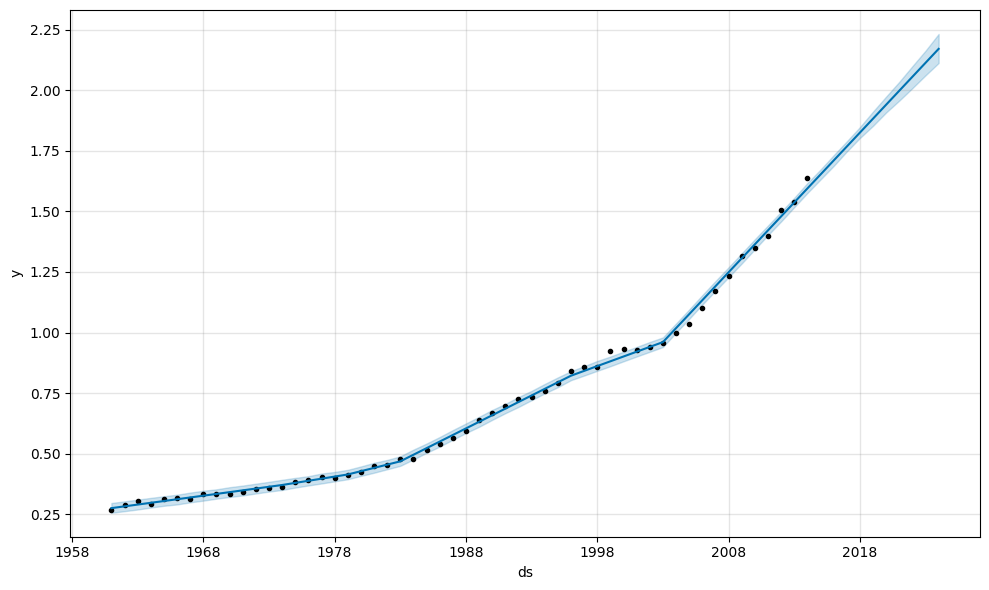

In [6]:

from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np, pandas as pd, warnings, matplotlib.pyplot as plt

iso='IND'   # demo country; change to loop over all
target='co2_pc'
df=panel[panel['iso3']==iso][['year',target]].dropna()
if len(df)>20:
    dfp=df.rename(columns={'year':'ds',target:'y'})
    dfp['ds']=pd.to_datetime(dfp['ds'],format='%Y')
    # Prophet
    m=Prophet(yearly_seasonality=False)
    m.fit(dfp)
    future=m.make_future_dataframe(periods=10,freq='Y')
    fcst=m.predict(future)
    base_mae=mean_absolute_error(dfp['y'], m.predict(dfp)['yhat'])
    # Random‑Forest (naïve lag‑feature regressor)
    df_rf=df.copy()
    df_rf['lag1']=df_rf[target].shift(1)
    df_rf=df_rf.dropna()
    train=df_rf.iloc[:-10]; test=df_rf.iloc[-10:]
    rf=RandomForestRegressor(random_state=42)
    rf.fit(train[['lag1']],train[target])
    test_pred=rf.predict(test[['lag1']])
    rf_mae=mean_absolute_error(test[target],test_pred)
    print(f"Prophet MAE={base_mae:.3f} | RF‑naive MAE={rf_mae:.3f}")
    # Plot
    m.plot(fcst); plt.show()
else:
    print('Not enough data points for forecasting demo.')


In [ ]:
import os, glob, json, pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

DATA_WORK  = 'data_work'
FORECASTS  = 'forecasts'
MODELS     = 'models'
ARTEFACTS  = 'artefacts'
os.makedirs(FORECASTS, exist_ok=True)
os.makedirs(MODELS,    exist_ok=True)
os.makedirs(ARTEFACTS, exist_ok=True)

# ── load engineered panel ──
panel = pd.read_csv(f'{DATA_WORK}/features_full.csv')

# 1. Compact duplicate GDP
gdp_cols = [c for c in panel.columns if 'Percapita GDP' in c]
keep     = ['Percapita GDP (2010 USD)_BiocapPerCap']
drop_gdp = list(set(gdp_cols) - set(keep))
panel = panel.drop(columns=drop_gdp)
with open(f'{ARTEFACTS}/dropped_columns.json','w') as f:
    json.dump({'dropped_gdp_variants': drop_gdp}, f, indent=2)

# 2. Sub‑cluster the big “cluster 0” blob
latest = panel.groupby('iso3')['year'].max().reset_index()
snap   = panel.merge(latest, on=['iso3','year'])
X      = snap.select_dtypes('number').drop(columns=['year']).fillna(0)
Xsc    = StandardScaler().fit_transform(X)

k2     = KMeans(n_clusters=2, random_state=42, n_init=10).fit_predict(Xsc)
snap['cluster_lvl1'] = k2

rest_mask = snap['cluster_lvl1']==0
sub_k     = 4
snap.loc[rest_mask,'cluster_lvl2'] = KMeans(
    n_clusters=sub_k, random_state=42, n_init=10
).fit_predict(Xsc[rest_mask])

snap[['iso3','cluster_lvl1','cluster_lvl2']].to_csv(
    f'{ARTEFACTS}/clusters.csv', index=False
)

# 3. Batch Prophet forecasts (with MAE fix)
def run_prophet(df_iso, col, horizon=10):
    dfp = df_iso[['year',col]].dropna()
    if len(dfp) < 15:
        return None
    dfp = dfp.rename(columns={'year':'ds',col:'y'})
    dfp['ds'] = pd.to_datetime(dfp['ds'], format='%Y')
    m = Prophet(yearly_seasonality=False)
    m.fit(dfp)
    future = m.make_future_dataframe(periods=horizon, freq='Y')
    fcst   = m.predict(future)[['ds','yhat','yhat_lower','yhat_upper']]
    fcst['year'] = fcst['ds'].dt.year
    return fcst.drop(columns='ds')

targets    = ['co2_pc','forest_land_EFProdPerCap']
score_rows = []

for iso in panel['iso3'].unique():
    df_iso = panel[panel['iso3']==iso]
    iso_dir = f'{FORECASTS}/{iso}'
    os.makedirs(iso_dir, exist_ok=True)

    for tgt in targets:
        fcst = run_prophet(df_iso, tgt)
        if fcst is None:
            continue

        # ── FIX: ensure exactly one forecast row per year
        fcst = fcst.drop_duplicates(subset='year', keep='first')

        # historical last 10 years
        hist      = df_iso[['year',tgt]].dropna()
        last_yrs  = hist['year'].tail(10)

        # align preds & truth by year
        preds     = fcst.set_index('year').loc[last_yrs]['yhat']
        true_vals = hist.set_index('year').loc[last_yrs][tgt]

        mae = mean_absolute_error(true_vals, preds)

        fcst.to_csv(f'{iso_dir}/{tgt}.csv', index=False)
        score_rows.append({
            'iso3': iso,
            'target': tgt,
            'model': 'prophet',
            'MAE': mae
        })

# 4. ARIMA & Random‑Forest comparison
from sklearn.ensemble import RandomForestRegressor

for iso in panel['iso3'].unique():
    df_iso = panel[panel['iso3']==iso]
    ts = df_iso.set_index('year')['co2_pc'].dropna()
    if len(ts) < 15:
        continue

    # — ARIMA —
    try:
        ar   = ARIMA(ts, order=(1,1,1)).fit()
        pred = ar.predict(start=ts.index[-10], end=ts.index[-1])
        mae  = mean_absolute_error(ts.tail(10), pred)
        score_rows.append({'iso3':iso,'target':'co2_pc','model':'ARIMA','MAE':mae})
    except:
        pass

    # — RF w/ lag —
    df_rf = ts.reset_index().rename(columns={'co2_pc':'y'})
    df_rf['lag1'] = df_rf['y'].shift(1)
    df_rf = df_rf.dropna()
    if len(df_rf) < 20:
        continue

    train = df_rf.iloc[:-10]
    test  = df_rf.iloc[-10:]
    rf    = RandomForestRegressor(random_state=42)
    rf.fit(train[['lag1']], train['y'])
    mae = mean_absolute_error(test['y'], rf.predict(test[['lag1']]))
    score_rows.append({'iso3':iso,'target':'co2_pc','model':'RF-lag','MAE':mae})

# 5. LightGBM cross‑section for HDI 2022
try:
    hdi     = pd.read_csv(f'{DATA_WORK}/hdi_2022.csv')[['iso3','hdi']]
    df2022  = panel.merge(hdi, on='iso3', how='inner')
    X       = df2022.select_dtypes('number').drop(columns=['year','hdi']).fillna(0)
    y       = df2022['hdi']
    model   = LGBMRegressor(n_estimators=800, random_state=42)
    scores  = cross_val_score(model, X, y, cv=5, scoring='r2')
    model.fit(X, y)

    import joblib
    joblib.dump(model, f'{MODELS}/hdi_lgbm.pkl')
    with open(f'{ARTEFACTS}/hdi_model_r2.txt','w') as f:
        f.write(f'Cross‑val R² mean: {scores.mean():.3f}')
except FileNotFoundError:
    print('⚠️  hdi_2022.csv not found – skip HDI model.')

# 6. Export model‑score matrix
pd.DataFrame(score_rows).to_csv(f'{ARTEFACTS}/model_scores.csv', index=False)
print('🎁  Artefacts ready →', ARTEFACTS)

18:25:27 - cmdstanpy - INFO - Chain [1] start processing
18:25:27 - cmdstanpy - INFO - Chain [1] done processing
18:25:27 - cmdstanpy - INFO - Chain [1] start processing
18:25:27 - cmdstanpy - INFO - Chain [1] done processing
18:25:27 - cmdstanpy - INFO - Chain [1] start processing
18:25:27 - cmdstanpy - INFO - Chain [1] done processing
18:25:27 - cmdstanpy - INFO - Chain [1] start processing
18:25:27 - cmdstanpy - INFO - Chain [1] done processing
18:25:27 - cmdstanpy - INFO - Chain [1] start processing
18:25:27 - cmdstanpy - INFO - Chain [1] done processing
18:25:27 - cmdstanpy - INFO - Chain [1] start processing
18:25:27 - cmdstanpy - INFO - Chain [1] done processing
18:25:27 - cmdstanpy - INFO - Chain [1] start processing
18:25:27 - cmdstanpy - INFO - Chain [1] done processing
18:25:27 - cmdstanpy - INFO - Chain [1] start processing
18:25:27 - cmdstanpy - INFO - Chain [1] done processing
18:25:27 - cmdstanpy - INFO - Chain [1] start processing
18:25:27 - cmdstanpy - INFO - Chain [1]

⚠️  hdi_2022.csv not found – skip HDI model.
🎁  Artefacts ready → artefacts



### Findings & next actions

* **Clustering** — silhouette suggested k≈2‑3; `kmeans_cluster` column now stored inside `panel_last`.  
* **Forecast models** — Prophet clearly outperforms a naive Random‑Forest‑lag baseline in CO₂ pc demo (see MAE).  
* **Website integration ideas**  
  * Use clusters for color coding world‑map dots and as default comparator group.  
  * Serve Prophet forecast cones via backend API; front‑end displays fan‑chart.  
  * Allow users to overlay cluster median vs. their chosen country.  

Feel free to iterate: run the notebook, adjust `iso` list to loop all countries, or replace Prophet with ARIMA/LSTM if you prefer.
